# Programming your solver

In this notebook, we will look at some of the more advanced capabilities Firedrake has for configuring and developing preconditioners. In particular, we will show support for geometric multigrid, as well as user-defined preconditioners.

As our prototypical example, we will consider the Stokes equations. Find $(u, p) \in V \times Q \subset (H^1)^d \times L^2$ such that

$$
\begin{align}
  \nu\int_\Omega \nabla u : \nabla v\,\mathrm{d}x - \int_\Omega p
  \nabla \cdot v\,\mathrm{d}x
  &= \int_\Omega f \cdot v\,\mathrm{d}x, \\
  -\int_\Omega \nabla \cdot u q \,\mathrm{d}x&= 0.
\end{align}
$$
for all $(v, q) \in V \times Q$. Where $\nu$ is the viscosity.

We will use the inf-sup stable Taylor-Hood element pair of piecewise quadratic velocities and piecewise linear pressures.

In [1]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [2]:
from firedrake import *
mesh = UnitSquareMesh(8, 8)

[IC-D46G33P392:20049] shmem: mmap: an error occurred while determining whether or not /var/folders/4g/kvmb0gkn7t59x2_pjvrrk9nh0000gp/T//ompi.IC-D46G33P392.502/jf.0/2215182336/sm_segment.IC-D46G33P392.502.84090000.0 could be created.


We now build a hierarchy of regularly refined meshes with this as the coarsest mesh, and grab the finest one to define the problem.

In [3]:
meshes = MeshHierarchy(mesh, refinement_levels=3)
# Grab the finest mesh
mesh = meshes[-1]

V = VectorFunctionSpace(mesh, "Lagrange", 2)
Q = FunctionSpace(mesh, "Lagrange", 1)
W = V*Q

We set up the problem in residual form (using `TestFunction`s but no `TrialFunction`s).

In [4]:
v, q = TestFunctions(W)
w = Function(W)
u, p = split(w)

nu = Constant(0.0001)
F = nu*inner(grad(u), grad(v))*dx - p*div(v)*dx - div(u)*q*dx

We now need to augment the problem with a forcing term and boundary conditions.  We will solve a regularised lid-driven cavity problem, and thus choose $f = 0$ and the boundary conditions:
$$
\begin{align}
u &= \begin{pmatrix}\frac{x^2 (2 - x)^2 y^2}{4} \\ 0 \end{pmatrix} & \text{ on $\Gamma_1 = \{y = 1\}$},\\
u &= 0 & \text{ otherwise.}\\
\end{align}
$$

In [5]:
x, y = SpatialCoordinate(mesh)
bc_value = as_vector([0.25 * x**2 * (2-x)**2 *y**2, 0])

bcs = [DirichletBC(W.sub(0), bc_value, 4),
       DirichletBC(W.sub(0), zero(mesh.geometric_dimension()), (1, 2, 3))]

This problem has a null space of constant pressures, so we'll need to inform the solver about that too.

In [6]:
nullspace = MixedVectorSpaceBasis(W, [W.sub(0), VectorSpaceBasis(constant=True)])

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


Since we're going to look at a bunch of different solver options, let's have a function that builds a solver with the provided options.

In [7]:
def create_solver(solver_parameters, *, pmat=None, appctx=None):
    p = {}
    if solver_parameters is not None:
        p.update(solver_parameters)
    # Default to linear SNES
    p.setdefault("snes_type", "ksponly")
    p.setdefault("ksp_rtol", 1e-7)
    problem = NonlinearVariationalProblem(F, w, bcs=bcs, Jp=pmat)
    solver = NonlinearVariationalSolver(problem, nullspace=nullspace, options_prefix="", 
                                        solver_parameters=p, appctx=appctx)
    return solver

First, let's go ahead and solve the problem using a direct solver. The solver is configured with a dictionary of PETSc options. Here we select MUMPS to perform the sparse LU factorisation. (Note that these are actually the default solver parameters that Firedrake assumes.)

In [8]:
solver_parameters = {
    "mat_type": "aij",
    "ksp_type": "preonly",
    # Use MUMPS since it handles the null space
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps"
}

In [9]:
# Programmatically inspect convergence of solver
def convergence(solver):
    from firedrake.solving_utils import KSPReasons, SNESReasons
    snes = solver.snes
    print("""
SNES iterations: {snes}; SNES converged reason: {snesreason}
   KSP iterations: {ksp}; KSP converged reason: {kspreason}""".format(snes=snes.getIterationNumber(),
                                                                      snesreason=SNESReasons[snes.getConvergedReason()],
                                                                      ksp=snes.ksp.getIterationNumber(),
                                                                      kspreason=KSPReasons[snes.ksp.getConvergedReason()]))

We're ready to solve.

In [10]:
w.assign(0)
solver = create_solver(solver_parameters)
solver.solve()
convergence(solver)


SNES iterations: 1; SNES converged reason: CONVERGED_ITS
   KSP iterations: 1; KSP converged reason: CONVERGED_ITS


We can now have a look at the solution, using some simple builtin plotting that utilises matplotlib.

/Users/dham/src/firedrake-petsc/firedrake/firedrake/pyplot/mpl.py:395: RuntimeWarning: divide by zero encountered in scalar divide
  dt = 0.5 * r / np.sqrt(np.sum(v1**2))
/Users/dham/src/firedrake-petsc/firedrake/firedrake/pyplot/mpl.py:399: RuntimeWarning: invalid value encountered in multiply
  v2 = toreal(direction * function.at(x + dt * v1, tolerance=loc_tolerance),


ValueError: Points to evaluate are inconsistent among processes.

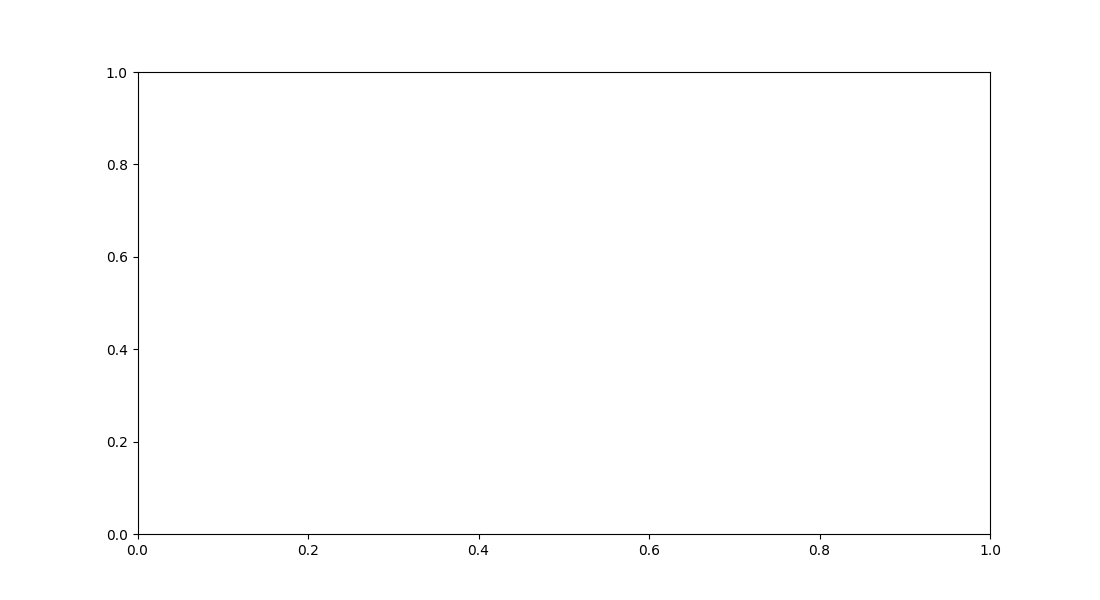

In [11]:
from firedrake.pyplot import streamplot

u_h, p_h = w.subfunctions
fig, axes = plt.subplots()
streamlines = streamplot(u_h, resolution=1/30, seed=0, axes=axes)
fig.colorbar(streamlines);

## Configuring a better preconditioner

For this small problem, we can (and probably should) use a direct factorisation method. But what if the problem is too big? Then we need an iterative method, and an appropriate preconditioner.

Let's try everyone's favourite, ILU(0).

In [12]:
solver_parameters = {
    "mat_type": "aij",
    "ksp_type": "gmres",
    "ksp_gmres_modifiedgramschmidt": None,
    "ksp_max_it": 2000,
    "ksp_converged_reason": None,
    "pc_type": "ilu"
}

In [13]:
w.assign(0)
solver = create_solver(solver_parameters)
solver.solve()
convergence(solver)

    Linear  solve converged due to CONVERGED_RTOL iterations 960

SNES iterations: 1; SNES converged reason: CONVERGED_ITS
   KSP iterations: 960; KSP converged reason: CONVERGED_RTOL


This is, unsurprisingly, bad. Fortunately, better options are available.

### Block preconditioning

Firedrake hooks up all the necessary machinery to access PETSc's [`PCFIELDSPLIT`](https://www.mcs.anl.gov/petsc/petsc-current/manualpages/PC/PCFIELDSPLIT.html#PCFIELDSPLIT) preconditioner. This provides mechanisms for building preconditioners based on block factorisations. The Stokes problem 
$$
\begin{align}
  \nu\int_\Omega \color{#800020}{\nabla u : \nabla v}\,\mathrm{d}x - \int_\Omega
  \color{#2A52BE}{p \nabla \cdot v}\,\mathrm{d}x
  &= \int_\Omega f \cdot v\,\mathrm{d}x, \\
  -\int_\Omega \color{#2A52BE}{\nabla \cdot u q} \,\mathrm{d}x&= 0
\end{align}
$$
is a block system with matrix
$$
\mathcal{A} = \begin{bmatrix} \color{#800020}{A} & \color{#2A52BE}{B^T} \\ \color{#2A52BE}{B} & 0 \end{bmatrix},
$$

admitting a factorisation

$$
\begin{bmatrix} I & 0 \\ \color{#2A52BE}{B} \color{#800020}{A}^{-1} & I\end{bmatrix}
\begin{bmatrix}\color{#800020}{A} & 0 \\ 0 & S\end{bmatrix}
\begin{bmatrix} I & \color{#800020}{A}^{-1} \color{#2A52BE}{B^T} \\ 0 & I\end{bmatrix},
$$

with $S = -\color{#2A52BE}{B} \color{#800020}{A}^{-1} \color{#2A52BE}{B^T}$ the *Schur complement*.  This has an inverse

$$
\begin{bmatrix} I & -\color{#800020}{A}^{-1}\color{#2A52BE}{B^T} \\ 0 & I \end{bmatrix}
\begin{bmatrix} \color{#800020}{A}^{-1} & 0 \\ 0 & S^{-1}\end{bmatrix}
\begin{bmatrix} I & 0 \\ -\color{#2A52BE}{B}\color{#800020}{A}^{-1} & I\end{bmatrix}.
$$

$S$ is never formed, so it's inverse is approximated using an iterative method.

In [14]:
exact_inverse_parameters = {
    "ksp_type": "fgmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
    "fieldsplit_1": {
        "ksp_type": "cg",
        "ksp_rtol": 1e-8,
        "pc_type": "none",
    }
}

In [15]:
w.assign(0)
solver = create_solver(exact_inverse_parameters)
solver.solve()
convergence(solver)


SNES iterations: 1; SNES converged reason: CONVERGED_ITS
   KSP iterations: 1; KSP converged reason: CONVERGED_RTOL


This looks good, but we had to use an unpreconditioned Krylov method to invert $S$. To do better we need to provide either an approximation to $S$ or $S^{-1}$.

For the Stokes equations, [Silvester and Wathen (1993)](https://epubs.siam.org/doi/10.1137/0730031) show that $S \approx -\nu^{-1} Q$ is a good approximation, where $Q$ is the pressure mass matrix.

Problem: $Q$ is not available as one of the blocks of $\mathcal{A}$.

PETSc's approach is to allow us to supply a _separate_ matrix to the solver which will be used to construct the preconditioner. So, we just need to additionally supply

$$
\mathcal{P} = \mathcal{A} + \begin{bmatrix} 0 & 0 \\ 0 & -\nu^{-1}Q\end{bmatrix} = \begin{bmatrix} \color{#800020}{A} & \color{#2A52BE}{B^T} \\ \color{#2A52BE}{B} & -\nu^{-1} Q \end{bmatrix},
$$
where $Q = \int_\Omega p q \,\mathrm{d}x$.

We will construct P by symbolically computing the derivative of the residual to get $\mathcal{A}$ and then subtracting $\nu^{-1} Q$.

In [16]:
w_t = TrialFunction(W)
_, p_t = split(w_t)

pmat = lhs(derivative(F, w, w_t)) - 1/nu * p_t * q*dx

We can now pass this pmat form to `create_solver` and can configure an appropriate preconditioner.

In [17]:
pmat_parameters = {
    "mat_type": "nest", # We only need the blocks
    "snes_type": "ksponly",
    "ksp_view": None,
    "ksp_monitor_true_residual": None,
    "ksp_max_it": 100,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
    "fieldsplit_1": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    }
}

In [18]:
w.assign(0)
solver = create_solver(pmat_parameters, pmat=pmat)
solver.solve()
convergence(solver)

    Residual norms for  solve.
    0 KSP preconditioned resid norm 5.496162170027e+00 true resid norm 7.005934058591e-04 ||r(i)||/||b|| 1.000000000000e+00
    1 KSP preconditioned resid norm 9.288239850613e-01 true resid norm 2.453830661658e-03 ||r(i)||/||b|| 3.502503222463e+00
    2 KSP preconditioned resid norm 4.322571804188e-01 true resid norm 1.513282272808e-03 ||r(i)||/||b|| 2.160000736736e+00
    3 KSP preconditioned resid norm 9.747752360343e-02 true resid norm 4.889677087760e-04 ||r(i)||/||b|| 6.979336440891e-01
    4 KSP preconditioned resid norm 2.168769655066e-02 true resid norm 2.367419610199e-04 ||r(i)||/||b|| 3.379163421180e-01
    5 KSP preconditioned resid norm 6.602391994115e-03 true resid norm 1.323183601895e-04 ||r(i)||/||b|| 1.888661227510e-01
    6 KSP preconditioned resid norm 3.201127617588e-03 true resid norm 5.559951302407e-05 ||r(i)||/||b|| 7.936059997010e-02
    7 KSP preconditioned resid norm 1.583402976265e-03 true resid norm 1.881712632761e-05 ||r(i)||/||

### Providing auxiliary operators

An inconvenience here is that we must build $\mathcal{P}$, even though we only need $-\nu^{-1} Q$ in additional to $\mathcal{A}$ in the preconditioner.

Firedrake offers a facilities to build Python preconditioning objects, utilising petsc4py.

In this case, we can subclass the 
[`AuxiliaryOperatorPC`](https://www.firedrakeproject.org/firedrake.preconditioners.html#firedrake.preconditioners.assembled.AuxiliaryOperatorPC) to provide the mass matrix.

In [19]:
class MassMatrix(AuxiliaryOperatorPC):
    _prefix = "mass_"
    def form(self, pc, test, trial):
        # Grab the definition of nu from the user application context (a dict)
        nu = self.get_appctx(pc)["nu"]
        return (-1/nu * test*trial*dx, None)

Now we just need to select parameters such that this Python preconditioner is used.

In [20]:
mass_parameters = {
    "mat_type": "nest", # We only need the blocks
    "ksp_view": None,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
    "fieldsplit_1": {
        "ksp_type": "preonly",
        "pc_type": "python",
        "pc_python_type": "__main__.MassMatrix",
        "mass_pc_type": "lu",
    }
}

In [21]:
appctx = {"nu": nu} # arbitrary user data that is available inside the user PC object
w.assign(0)
solver = create_solver(mass_parameters, appctx=appctx)
solver.solve()
convergence(solver)

KSP Object: () 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=10000, initial guess is zero
  tolerances: relative=1e-07, absolute=1e-50, divergence=10000.
  left preconditioning
  using PRECONDITIONED norm type for convergence test
PC Object: () 1 MPI process
  type: fieldsplit
    FieldSplit with Schur preconditioner, factorization FULL
    Preconditioner for the Schur complement formed from A11
    Split info:
    Split number 0 Defined by IS
    Split number 1 Defined by IS
    KSP solver for A00 block
      KSP Object: (fieldsplit_0_) 1 MPI process
        type: preonly
        maximum iterations=10000, initial guess is zero
        tolerances: relative=1e-05, absolute=1e-50, divergence=10000.
        left preconditioning
        using NONE norm type for convergence test
      PC Object: (fieldsplit_0_) 1 MPI process
        type: lu
       

This performs identically to the previous approach, except that the preconditioning matrix is only built for the pressure space, and constructed "on demand".

## Multigrid preconditioners and smoothers

So far, we've only used direct solvers for the blocks. We can also use iterative methods. Here we'll use geometric multigrid to solve

In the same way that Firedrake hooks up solvers such that [`PCFIELDSPLIT`](https://www.mcs.anl.gov/petsc/petsc-current/manualpages/PC/PCFIELDSPLIT.html#PCFIELDSPLIT) is enabled, if a problem was defined on a mesh from a `MeshHierarchy`, [`PCMG`](https://www.mcs.anl.gov/petsc/petsc-current/manualpages/PC/PCMG.html) and [`SNESFAS`](https://www.mcs.anl.gov/petsc/petsc-current/manualpages/SNES/SNESFASType.html) are also available.

In [22]:
fieldsplit_mg_parameters = {
    "mat_type": "nest",
    "ksp_view": None,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "mg",
        "mg_levels": {
            "ksp_type": "chebyshev",
            "ksp_max_it": 2,
        }
    },
    "fieldsplit_1": {
        "ksp_type": "chebyshev",
        "ksp_max_it": 2,
        "pc_type": "python",
        "pc_python_type": "__main__.MassMatrix",
        "mass_pc_type": "sor",
    }
}

Now, when the solver runs, PETSc will call back in to Firedrake for restriction and prolongation, as well as rediscretising $A$ on the coarser levels.

In [23]:
appctx = {"nu": nu} # arbitrary user data that is available inside the user PC object
w.assign(0)
solver = create_solver(fieldsplit_mg_parameters, appctx=appctx)
solver.solve()
convergence(solver)

KSP Object: () 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=10000, initial guess is zero
  tolerances: relative=1e-07, absolute=1e-50, divergence=10000.
  left preconditioning
  using PRECONDITIONED norm type for convergence test
PC Object: () 1 MPI process
  type: fieldsplit
    FieldSplit with Schur preconditioner, factorization FULL
    Preconditioner for the Schur complement formed from A11
    Split info:
    Split number 0 Defined by IS
    Split number 1 Defined by IS
    KSP solver for A00 block
      KSP Object: (fieldsplit_0_) 1 MPI process
        type: preonly
        maximum iterations=10000, initial guess is zero
        tolerances: relative=1e-05, absolute=1e-50, divergence=10000.
        left preconditioning
        using NONE norm type for convergence test
      PC Object: (fieldsplit_0_) 1 MPI process
        type: mg
       

We can also do monolithic, or "all at once" multigrid. Here we're using Vanka smoothing. This is supported by a new preconditioner in PETSc `PCPATCH`.

In [24]:
vanka_parameters = {
    "mat_type": "matfree", # We only need the action
    "ksp_type": "fgmres",
    "ksp_max_it": 25,
    "pc_type": "mg",
    "mg_levels": {
        "ksp_type": "chebyshev",
        "ksp_convergence_test": "skip",
        "ksp_max_it": 2,
        "pc_type": "python",
        "pc_python_type": "firedrake.PatchPC",
        "patch": {
            "pc_patch_save_operators": 1,
            "pc_patch_partition_of_unity": False,
            "pc_patch_construct_dim": 0,
            # Topological decomposition
            "pc_patch_construct_type": "vanka",
            # Pressure space is constraint space
            "pc_patch_exclude_subspaces": 1,
            # Configure the solver on each patch
            "pc_patch_sub": {
                "mat_type": "dense",
                "ksp_type": "preonly",
                "pc_type": "lu",
                "pc_factor_shift_type": "nonzero",
            }
        }
    },
    "mg_coarse": {
        "ksp_type": "preonly",
        "pc_type": "python",
        "pc_python_type": "firedrake.AssembledPC",
        "assembled": {
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
        }
    }
}

The solver can be invoked as below, but frequently crashes Jupyter notebooks:

In [25]:
#w.assign(0)
#solver = create_solver(vanka_parameters)
#solver.solve()
#convergence(solver)